In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

plt.rcParams['pdf.fonttype'] = 42

# General utils
from tqdm import tqdm
from os import path

from aicsshparam import shtools
import pyvista as pv
import ipyvolume as ipv

def reconstruct_mesh(coeffs,lmax=5):
    coeffs = coeffs.to_dict()
    coeffs = {'_'.join(k.split('_')[1:3]):v for k,v in coeffs.items()}
    # Convert to matrix
    mat = np.zeros((2, lmax + 1, lmax + 1), dtype=np.float32)
    for L in range(lmax):
        for M in range(L + 1):
            for cid, C in enumerate(["C", "S"]):
                key = f"shcoeffs_L{L}M{M}{C}"
                if key in coeffs.keys():
                    mat[cid, L, M] = coeffs[key]
                else:
                    mat[cid,L,M] = 0
    mesh = shtools.get_even_reconstruction_from_coeffs(mat)
    return mesh


In [35]:
# print(divisions[both_fate_known].groupby(('Num daughter differentiated','Meta')).count()/ 303)
# divisions[both_fate_known].groupby([('Region',''),('Num daughter differentiated','Meta')]).count()/303

In [18]:
both_fate_known = pd.Series(index=divisions.index)
for idx, div in tqdm(divisions.iterrows()):
    a = div['Daughter a','Meta']
    a = div['Region'] + '_' + str(int(a))
    a_known = all_df.swaplevel(axis=0).loc[a,:].iloc[0]['Fate known','Meta']
    b = div['Daughter b','Meta']
    b = div['Region'] + '_' + str(int(b))
    b_known = all_df.swaplevel(axis=0).loc[b,:].iloc[0]['Fate known','Meta']
    both_fate_known.loc[idx] = a_known + b_known

668it [00:35, 19.04it/s]


In [177]:
print(all_df['Cell cycle duration','Measurement time'].reset_index().groupby('TrackID').mean().mean())
print(all_df['Cell cycle duration','Measurement time'].reset_index().groupby('TrackID').mean().std())

Frame                                     7.976507
Cell cycle duration  Measurement time    71.832402
dtype: float64
Frame                                     4.093157
Cell cycle duration  Measurement time    23.169933
dtype: float64


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_47481/2942338392.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(all_df['Cell cycle duration','Measurement time'].reset_index().groupby('TrackID').mean().mean())
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_47481/2942338392.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  print(all_df['Cell cycle duration','Measurement time'].reset_index().groupby('TrackID').mean().std())


In [161]:
fate_known = births[births['Fate known','Meta']]
divisions
# fate_known['Will differentiate'].sum() / len(fate_known['Will differentiate'])

Nuclear volume          Nuclear solidity  \
              Measurement nuclear shape Measurement nuclear shape   
Frame TrackID                                                       
1     R1_3                     116.6250                  0.848954   
      R1_4                     101.6875                  0.813500   
      R1_29                    151.6250                  0.854526   
      R1_30                    143.4375                  0.811815   
      R1_39                    138.8750                  0.915157   
...                                 ...                       ...   
11    R2_1064                  160.0625                  0.822943   
      R2_1065                  123.1250                  0.861767   
      R2_1112                  164.1250                  0.833916   
      R2_1135                  228.8750                  0.887973   
12    R2_1091                   99.5625                  0.789004   

                         Nuclear height            Cell volume  \
              Measurement nuclear shape Measurement cell shape   
Frame TrackID                                                    
1     R1_3                        -10.0               278.5000   
      R1_4                        -10.0               294.6250   
      R1_29                        -7.0               290.7500   
      R1_30                       -11.0               497.6875   
      R1_39                       -10.0               345.5625   
...                                 ...                    ...   
11    R2_1064                     -11.0               335.0625   
      R2_1065                      -9.0               373.6875   
      R2_1112                      -9.0               429.1875   
      R2_1135                     -13.0               508.8750   
12    R2_1091                     -11.0               400.3750   

                     Axial component     Planar component 1  \
              Measurement cell shape Measurement cell shape   
Frame TrackID                                                 
1     R1_3                  4.446682              11.724620   
      R1_4                  3.666467              16.110428   
      R1_29                 7.873362              10.517868   
      R1_30                 6.983466              18.506376   
      R1_39                 5.305974              12.787621   
...                              ...                    ...   
11    R2_1064               4.817940              16.957438   
      R2_1065               5.311741              14.781067   
      R2_1112               8.245330              14.261547   
      R2_1135               5.718846              22.543748   
12    R2_1091               4.877859              21.133471   

                  Planar component 2            Axial angle  \
              Measurement cell shape Measurement cell shape   
Frame TrackID                                                 
1     R1_3                 12.553037              11.676574   
      R1_4                 15.925634               1.038682   
      R1_29                 6.564180              13.295814   
      R1_30                21.180036              32.047837   
      R1_39                14.227551               7.089061   
...                              ...                    ...   
11    R2_1064              14.995789              22.474411   
      R2_1065              13.701728              24.000641   
      R2_1112              10.380062              27.823852   
      R2_1135              24.228097              16.769121   
12    R2_1091              22.824294              24.043524   

                        Planar angle                         Z  ...  \
              Measurement cell shape Measurement cell position  ...   
Frame TrackID                                                   ...   
1     R1_3                 89.760175                 45.346731  ...   
      R1_4                 91.192979                 46.580824  ...   
      R1_29 

In [3]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
figure_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Morphology differences'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
divisions_12h = pd.read_pickle(path.join(dataset_dir,f'divisions_12h.pkl'))
divisions_24h = pd.read_pickle(path.join(dataset_dir,f'divisions_24h.pkl'))
divisions_36h = pd.read_pickle(path.join(dataset_dir,f'divisions_36h.pkl'))
divisions_48h = pd.read_pickle(path.join(dataset_dir,f'divisions_48h.pkl'))
divisions_56h = pd.read_pickle(path.join(dataset_dir,f'divisions_56h.pkl'))
divisions_60h = pd.read_pickle(path.join(dataset_dir,f'divisions_60h.pkl'))
divisions_72h = pd.read_pickle(path.join(dataset_dir,f'divisions_72h.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

# Load the raw coeffs
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
            'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
regions = {name:pd.read_csv(path.join(dirname,'Mastodon/single_timepoints.csv')) for name,dirname in dirnames.items()}

cyto_coef_cols = [f for f in regions['R1'].columns if 'cyto_shcoeffs' in f and 'surface' not in f]
nuc_coef_cols = [f for f in regions['R1'].columns if 'nuc_shcoeffs' in f and 'surface' not in f]

coefs_raw = []
for name,region in regions.items():
    _cyto = region[cyto_coef_cols].copy()
    _cyto['Frame'] = region['Frame']
    _cyto['TrackID'] = name + '_' + region['TrackID'].astype(str)
    # _cyto['TrackID'] = region['TrackID']

    _nuc = region[nuc_coef_cols]
    _nuc['Frame'] = region['Frame']
    # _nuc['TrackID'] = region['TrackID']
    _nuc['TrackID'] = name + '_' + region['TrackID'].astype(str)
    
    coefs_raw.append(pd.merge(_cyto,_nuc, how='outer',left_on = ['Frame','TrackID'],right_on=['Frame','TrackID']))

coefs_raw = pd.concat(coefs_raw).set_index(['Frame','TrackID'],drop=True)

# Load the components/loadings
components = pd.read_csv('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles/pca_components.csv',
                        index_col=0)

# Load images
from skimage import io
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69258/2252492488.py:18: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  regions = {name:pd.read_csv(path.join(dirname,'Mastodon/single_timepoints.csv')) for name,dirname in dirnames.items()}
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_69258/2252492488.py:18: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58

KeyError: 'Frame'

In [7]:
coefs_raw

cyto_shcoeffs_L0M0C  cyto_shcoeffs_L1M0C  cyto_shcoeffs_L1M1C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001            18.073625             1.328395            -0.986114   
      R1_1004            15.391148             0.978029            -0.949218   
      R1_1011            16.853536            -0.147409             0.035420   
      R1_1012            18.679145             0.072176            -0.436054   
...                            ...                  ...                  ...   
14    R2_983             17.426294             0.811955             0.517346   
      R2_984             10.161426            -0.358595             0.634608   
      R2_987             14.716580             1.476706             0.790074   
      R2_991             17.477824             0.195771            -0.775873   
      R2_997             13.791526             0.658897            -0.469220   

               cyto_shcoeffs_L2M0C  cyto_shcoeffs_L2M1C  cyto_shcoeffs_L2M2C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001             1.593009             0.593728             1.451733   
      R1_1004             3.304739            -0.044184             1.489017   
      R1_1011             4.228108             0.540757             2.071124   
      R1_1012             4.453135             0.802721             1.156583   
...                            ...                  ...                  ...   
14    R2_983              4.117369            -0.090640             2.336483   
      R2_984              3.059200            -0.349240             2.977604   
      R2_987              4.834119             1.732055             0.531625   
      R2_991              5.242938            -0.384371             2.659684   
      R2_997              3.669043            -0.864643             2.697683   

               cyto_shcoeffs_L3M0C  cyto_shcoeffs_L3M1C  cyto_shcoeffs_L3M2C  \
Frame TrackID                                                                  
0     R1_1                     NaN                  NaN                  NaN   
      R1_1001            -0.236713             0.169947            -0.208674   
      R1_1004            -0.487778             0.229831             0.379443   
      R1_1011            -0.038461             0.070582             0.440860   
      R1_1012            -0.240342            -0.202024             0.341862   
...                            ...                  ...                  ...   
14    R2_983              0.146355             0.068409            -0.025837   
      R2_984             -0.016905             0.073007            -0.093718   
      R2_987              0.413540             0.124113             0.799024   
      R2_991             -0.406798             0.198847             0.700817   
      R2_997             -0.348237            -0.125359             0.611889   

               cyto_shcoeffs_L3M3C  ...  nuc_shcoeffs_L3M3S  \
Frame TrackID                       ...                       
0     R1_1                     NaN  ...           -0.037580   
      R1_1001             1.767237  ...            0.526629   
      R1_1004             0.739375  ...           -0.286768   
      R1_1011             0.388121  ...            0.077706   
      R1_1012             1.097893  ...            0.255754   
...                            ...  ...                 ...   
14    R2_983              0.060328  ...           -0.288074   
      R2_984             -0.192310  ...           -0.003404   
      R2_987             -1.547621  ...           -0.248675   
      R2_991              0.447537  ...            0.077289   
      R2_997              0.919203  ...           -0.446855   

               nuc_shcoeffs_L4M1S  nuc_shcoeffs_L4M2S  nuc_shcoeffs_L4M3

# Visualize PCA loadings

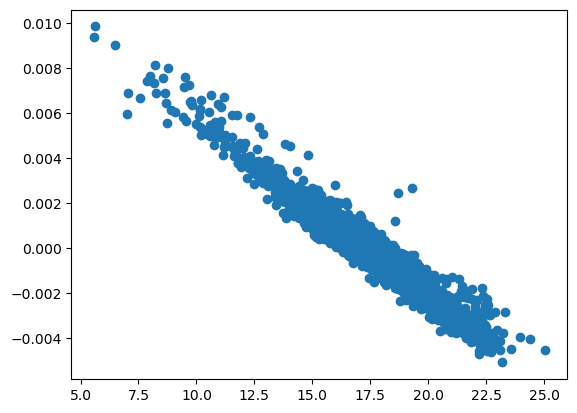

In [80]:
raw = coefs_raw['cyto_shcoeffs_L0M0C']
pc = all_df.droplevel(axis=1,level=1)[[f'nuc_shcoeff_PC{i}' for i in range(9)]]
df = pd.merge(raw,pc,left_index=True,right_index=True)

X = np.outer(components.loc['PC0'], df['nuc_shcoeff_PC0']).T
plt.scatter(raw,X[:,20])


In [92]:
## Get top/bottom by feature
# feature = 'nuc_shcoeff_PC3'
nuc_cols = components.columns.str.startswith('nuc_')
cyto_cols = components.columns.str.startswith('cyto_')
high = {'nuc':reconstruct_mesh(components.loc['PC0'][nuc_cols])[0],
        'cyto':reconstruct_mesh(components.loc['PC0'][cyto_cols])[0]}

high = {'nuc':reconstruct_mesh(-components.loc['PC0'][nuc_cols])[0],
        'cyto':reconstruct_mesh(-components.loc['PC0'][cyto_cols])[0]}

plot_cells_side_by_side([high])

Widget(value='<iframe src="http://localhost:59943/index.html?ui=P_0x403885b80_15&reconnect=auto" class="pyvist…

# Visualize the PCA exemplars

In [91]:
def plot_cells_side_by_side(cells,num_grid=None):
    num_cells = len(cells)
    if num_grid is None:
        num_grid = num_cells
        
    pl = pv.Plotter(shape=(1,num_grid))
    for i in range(num_grid):
        if i >= num_cells:
            continue
        pl.subplot(0,i)
        pl.add_mesh(pv.wrap(cells[i]['nuc']),color='r', opacity=0.5)
        pl.add_mesh(pv.wrap(cells[i]['cyto']),color='y', opacity=0.4)
        pl.add_axes()
    pl.link_views()
    pl.view_isometric()
    pv.Line((800, 400, 0), (800, 400, 20))
    pl.show()

def reconstruct_mesh_from_averaged_coeffs_(index,coeffs,cyto_col,nuc_col):
    mean_coeffs = coeffs.loc[index].mean()
    mean_cyto = mean_coeffs[cyto_col]
    mean_nuc = mean_coeffs[nuc_col]
    print(type(mean_coeffs))
    avg_cell = {'cyto':reconstruct_mesh(mean_cyto)[0],
                'nuc':reconstruct_mesh(mean_nuc)[0],
               }
    return avg_cell

def get_sorted_cell_indexes(df,feature):
    return df.droplevel(axis=1,level=1).dropna(subset=feature).sort_values(feature).index

In [93]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC0'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC1'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC2'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Widget(value='<iframe src="http://localhost:59943/index.html?ui=P_0x403aa8440_16&reconnect=auto" class="pyvist…

In [94]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC3'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC4'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC5'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Widget(value='<iframe src="http://localhost:59943/index.html?ui=P_0x31778d5e0_17&reconnect=auto" class="pyvist…

In [95]:
## Get top/bottom by feature
feature = 'nuc_shcoeff_PC6'
high = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC7'
high2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low2 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)

feature = 'nuc_shcoeff_PC8'
high3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[-10:],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)
low3 = reconstruct_mesh_from_averaged_coeffs_(get_sorted_cell_indexes(basals,feature)[:10],
                                   coefs_raw, cyto_coef_cols, nuc_coef_cols)


plot_cells_side_by_side([low,high,low2,high2,low3,high3])

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Widget(value='<iframe src="http://localhost:59943/index.html?ui=P_0x3da5c3aa0_18&reconnect=auto" class="pyvist…

In [219]:
from visualization import extract_nuc_and_cell_and_microenvironment_mask_from_idx

cell2view = basals.loc[get_sorted_cell_indexes(basals,'nuc_shcoeff_PC5')].droplevel(axis=1,level=1).iloc[-1]

(nuc,cyto,micro) = extract_nuc_and_cell_and_microenvironment_mask_from_idx(cell2view.name,
                                                                           adjdict_by_region,
                                                                           tracked_nuc_by_region,
                                                                           tracked_cyto_by_region)
ipv.quickvolshow(9*nuc + cyto, level=[.5,6], opacity=0.03, level_width=0.09, data_min=0, data_max=10)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.5, max=1.0, step…

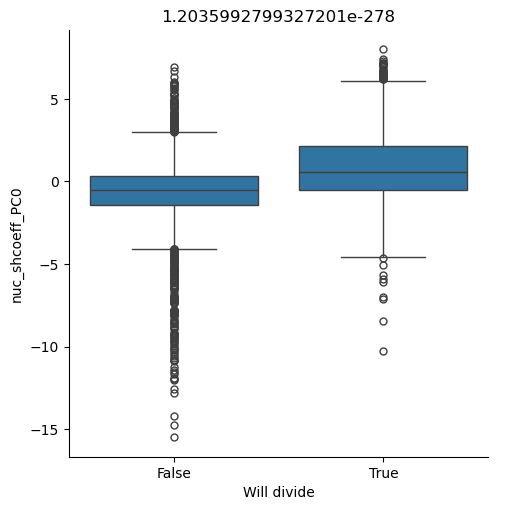

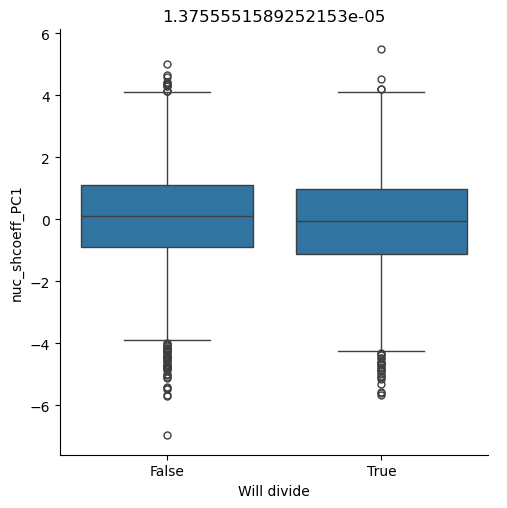

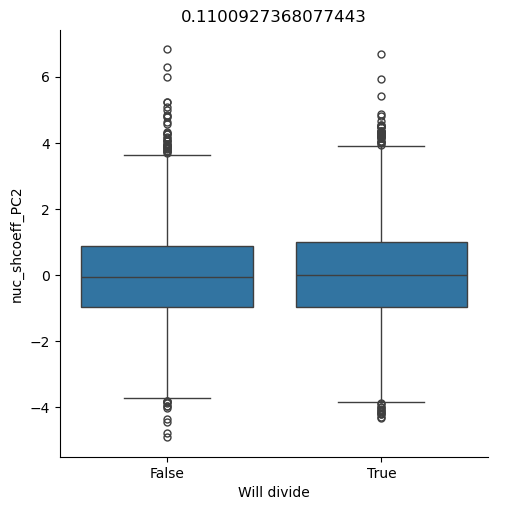

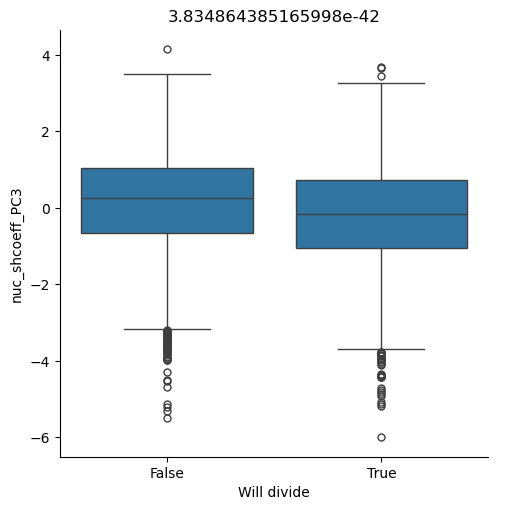

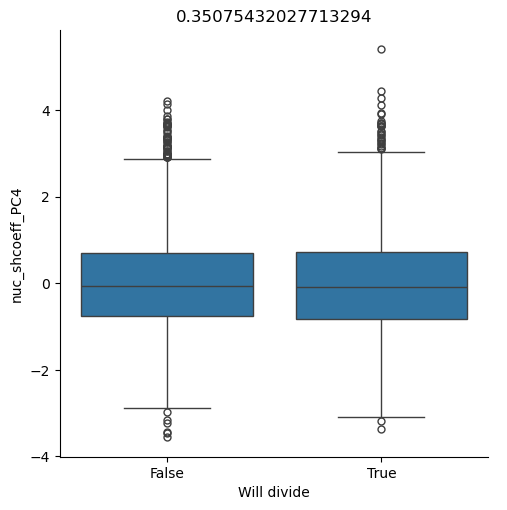

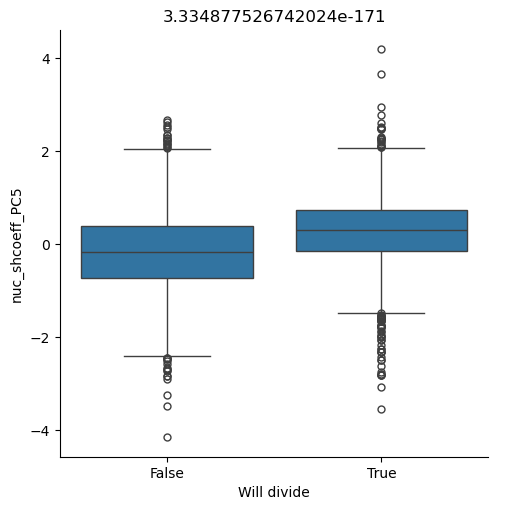

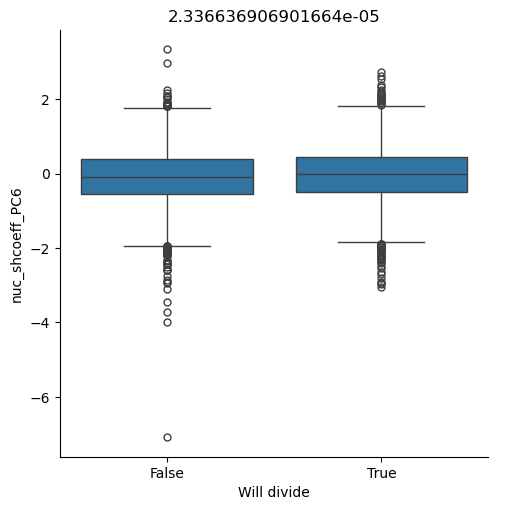

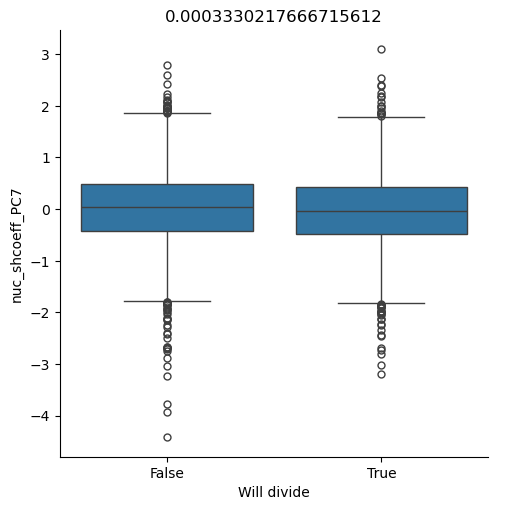

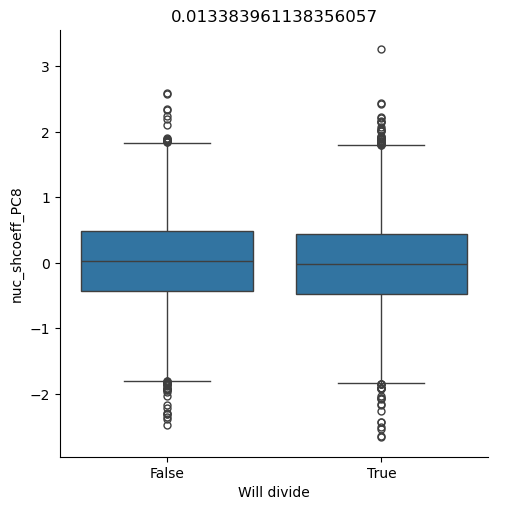

In [220]:
from basicUtils import ttest_from_groupby
# sb.catplot(divisions.droplevel(axis=1,level=1),x='Num daughter differentiated',y='nuc_shcoeff_PC6')
# sb.catplot(divisions.droplevel(axis=1,level=1),x='Cell cycle phase',y='nuc_shcoeff_PC0',kind='violin')
# sb.regplot(basals.droplevel(axis=1,level=1),x='Age',y='nuc_shcoeff_PC8')
for i in range(9):
    fig = sb.catplot(all_df.droplevel(axis=1,level=1),x='Will divide',y=f'nuc_shcoeff_PC{i}',kind='box')
    plt.title(ttest_from_groupby(all_df.droplevel(axis=1,level=1),field2group='Will divide',field2test=f'nuc_shcoeff_PC{i}')[1])
    fig.savefig(path.join(figure_dir,f'PCA_by_fate/PC{i}.svg'))

Name
nuc_shcoeff_PC0   -0.000886
nuc_shcoeff_PC1   -0.006650
nuc_shcoeff_PC2    0.008414
nuc_shcoeff_PC3    0.011619
nuc_shcoeff_PC4    0.011385
nuc_shcoeff_PC5    0.001079
nuc_shcoeff_PC6   -0.063821
nuc_shcoeff_PC7    0.007371
nuc_shcoeff_PC8    0.003454
dtype: float64

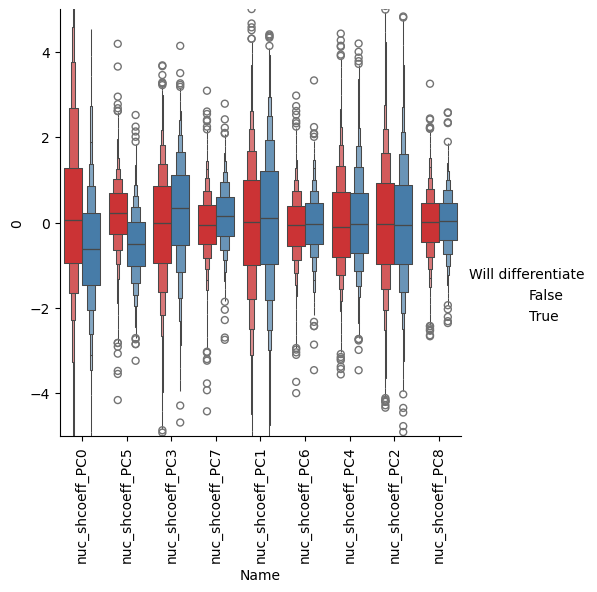

In [348]:
_mean = all_df.droplevel(axis=1,level=1)[[f'nuc_shcoeff_PC{i}' for i in range(9)]].std()
_diff = all_df.droplevel(axis=1,level=1).groupby('Will differentiate')[[f'nuc_shcoeff_PC{i}' for i in range(9)]].mean().diff()
order = (_diff / _mean.mean()).loc[True].T.abs().sort_values(ascending=False)
fig = sb.catplot(
    all_df.droplevel(axis=1,level=1).reset_index().set_index(['Frame','TrackID','Will differentiate'])[[f'nuc_shcoeff_PC{i}' for i in range(9)]].stack().reset_index(),
    x='Name',y=0,
    kind='boxen',palette='Set1',
   hue='Will differentiate',hue_order=[False,True],order=order.index)
plt.ylim([-5,5])
plt.xticks(rotation=90)

fig.savefig(path.join(figure_dir,'sorted_difference.svg'))

<Axes: xlabel='nuc_shcoeff_PC0', ylabel='Will differentiate'>

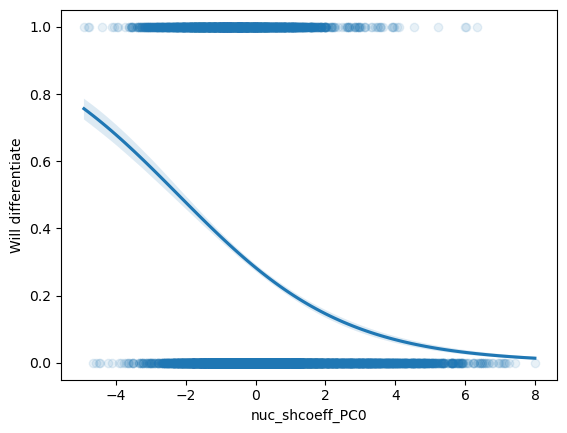

In [176]:
plt.close('all')
plt.figure()
sb.regplot(basals.droplevel(axis=1,level=1),
          x='nuc_shcoeff_PC0',y='Will differentiate',logistic=True,
         scatter_kws={'alpha':0.1})

# Average diff v. division

In [103]:
born = {trackID:track for trackID,track in basals.reset_index().droplevel(axis=1,level=1).groupby('TrackID')
        if track.iloc[0]['Born']}
born_and_divide = {trackID:track for trackID,track in basals.reset_index().droplevel(axis=1,level=1).groupby('TrackID')
             if track.iloc[0]['Born'] and track.iloc[0]['Will divide']}
born_and_diff = {trackID:track for trackID,track in basals.droplevel(axis=1,level=1).reset_index().groupby('TrackID')
             if track.iloc[0]['Born'] and track.iloc[0]['Will differentiate']}

len(born_and_divide)
len(born_and_diff)


431

In [104]:
def get_cellID(df,trackID):
    return df.swaplevel(axis=0).loc[trackID,:]

from matplotlib.colors import Normalize
from matplotlib import colormaps,cm
def plot_cell_movement(df,t='Frame',x='X',y='Y',cmap='hot',alpha=0.5,plot_scatter=False,colorbar=False):
    
    df = df.sort_values('Frame')
    #calculate displacements
    X = df[x]
    Y = df[y]
    t = df.reset_index()[t].values
    t = t - t[0]
    
    dX = np.diff(X.values)
    dX = np.pad(dX,(0,1),constant_values=np.nan)
    dY = np.diff(Y.values)
    dY = np.pad(dY,(0,1),constant_values=np.nan)

    norm = Normalize(vmin=0,vmax=150,clip=True)
    cmap = colormaps[cmap]
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    
    plt.axis('equal')
    if plot_scatter:
        plt.scatter(X,Y,color=color)
        
    plt.quiver(X,Y,dX,dY,
               color=cmap(norm(t[1:])),
               alpha=alpha, scale=1, units='xy',headwidth=2)
    
    if colorbar:
        plt.colorbar(sm,ax=plt.gca())
    return


## Cell cycle phase

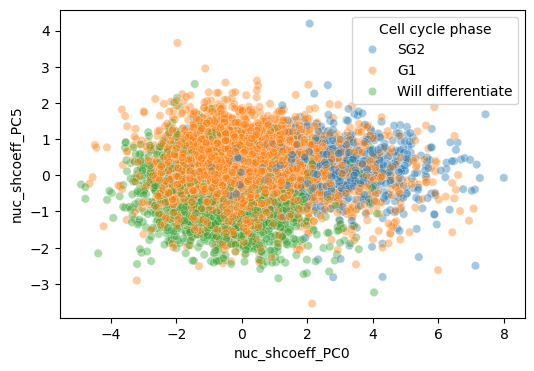

In [190]:
x = 'nuc_shcoeff_PC0'
y = 'nuc_shcoeff_PC5'

fig = plt.figure(figsize=(6,4))
phase_known = basals[basals['Cell cycle phase','Meta'] != 'NA'].droplevel(axis=1,level=1)
phase_known.loc[phase_known['Will differentiate'],'Cell cycle phase'] = 'Will differentiate'
sb.scatterplot(phase_known,x=x,y=y,alpha=0.4,hue='Cell cycle phase')
age_avg = pd.DataFrame.from_dict({age:_df[[x,y]].mean() for age,_df in pd.concat(born_and_divide.values()).groupby('Cell cycle phase')
                                 if len(_df) > 10}).T


In [191]:
plt.rcParams['svg.fonttype'] = 'none'


## Diff v. divide

In [115]:
from basicUtils import ttest_from_groupby
ttest_from_groupby(_df[_df['Age'] == 0],field2group='Will differentiate',field2test='nuc_shcoeff_PC5')
# help(ttest_from_groupby)

(np.float64(13.584124199820986), np.float64(1.8612136588931155e-39))

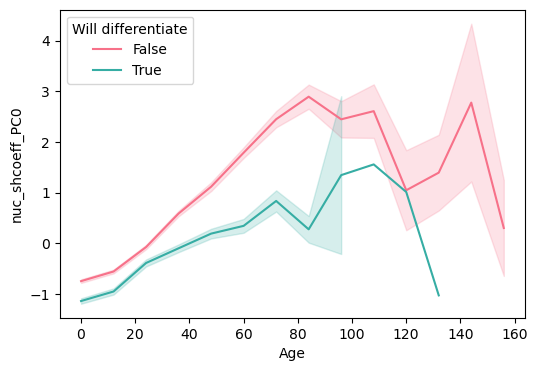

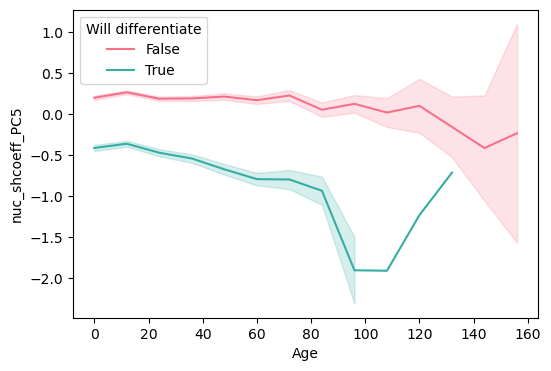

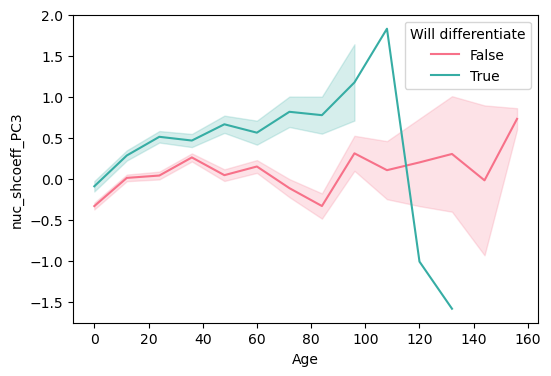

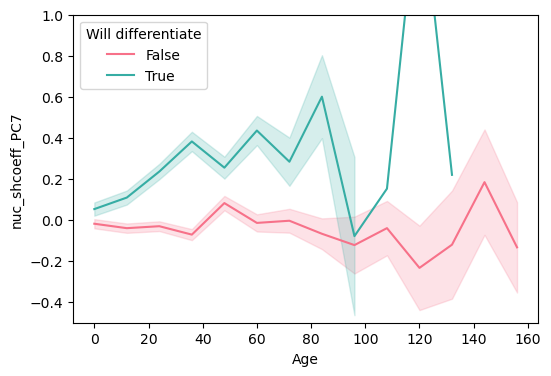

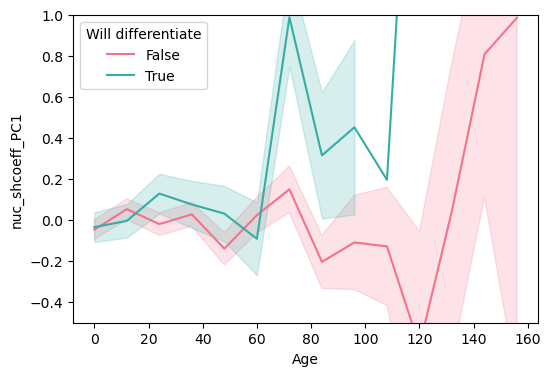

In [116]:
_df = pd.concat(born.values())

x = 'Age'
y = 'nuc_shcoeff_PC0'
fig = plt.figure(figsize=(6,4))
sb.lineplot(_df,x=x,y=y,hue='Will differentiate',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'PC0_trajectory.svg'))

y = 'nuc_shcoeff_PC5'
fig = plt.figure(figsize=(6,4))
sb.lineplot(_df,x=x,y=y,hue='Will differentiate',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'PC5_trajectory.svg'))

y = 'nuc_shcoeff_PC3'
fig = plt.figure(figsize=(6,4))
sb.lineplot(_df,x=x,y=y,hue='Will differentiate',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'PC3_trajectory.svg'))

y = 'nuc_shcoeff_PC7'
fig = plt.figure(figsize=(6,4))
sb.lineplot(_df,x=x,y=y,hue='Will differentiate',errorbar='se',palette='husl')
plt.ylim([-.5,1])
fig.savefig(path.join(figure_dir,'PC7_trajectory.svg'))

y = 'nuc_shcoeff_PC1'
fig = plt.figure(figsize=(6,4))
sb.lineplot(_df,x=x,y=y,hue='Will differentiate',errorbar='se',palette='husl')
plt.ylim([-.5,1])
fig.savefig(path.join(figure_dir,'PC1_trajectory.svg'))

# Average mother cells

In [97]:
divisions['Time to division'] = 0
divisions_12h['Time to division'] = -12
divisions_24h['Time to division'] = -24
divisions_36h['Time to division'] = -36
divisions_48h['Time to division'] = -48
divisions_56h['Time to division'] = -56
divisions_60h['Time to division'] = -60
divisions_72h['Time to division'] = -72

mother_traj = pd.concat((divisions,divisions_12h,divisions_24h,divisions_36h,divisions_48h,divisions_56h,divisions_60h))
mother_traj.index.set_names(('Frame','TrackID'),inplace=True)
mother_traj.droplevel(axis=1,level=1).reset_index()

mothers_sym_stem = mother_traj[mother_traj['Num daughter differentiated','Meta'] == 0].droplevel(axis=1,level=1)
mothers_asym = mother_traj[mother_traj['Num daughter differentiated','Meta'] == 1].droplevel(axis=1,level=1)
mothers_sym_diff = mother_traj[mother_traj['Num daughter differentiated','Meta'] == 2].droplevel(axis=1,level=1)

mothers_non_stem = mother_traj[mother_traj['At least one daughter differentiated','Meta'] == True].droplevel(axis=1,level=1)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_47481/978170648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  divisions_24h['Time to division'] = -24
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_47481/978170648.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  divisions_36h['Time to division'] = -36
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_47481/978170648.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [98]:
sym_stem = divisions[divisions['Num daughter differentiated','Meta'] == 0].index
asym = divisions[divisions['Num daughter differentiated','Meta'] == 1].index
sym_diff = divisions[divisions['Num daughter differentiated','Meta'] == 2].index

non_stem = divisions[divisions['At least one daughter differentiated','Meta'] == True].index

sym_stem = reconstruct_mesh_from_averaged_coeffs_(sym_stem,coefs_raw, cyto_coef_cols, nuc_coef_cols)
asym = reconstruct_mesh_from_averaged_coeffs_(asym,coefs_raw, cyto_coef_cols, nuc_coef_cols)
sym_diff = reconstruct_mesh_from_averaged_coeffs_(sym_diff,coefs_raw, cyto_coef_cols, nuc_coef_cols)

plot_cells_side_by_side([sym_stem,asym,sym_diff])

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Widget(value='<iframe src="http://localhost:59943/index.html?ui=P_0x3da5c2510_19&reconnect=auto" class="pyvist…

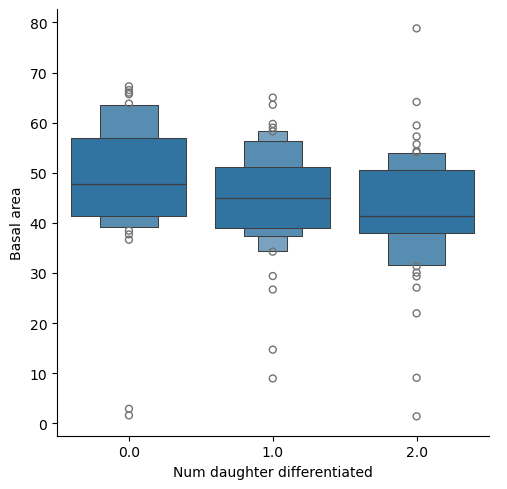

In [99]:
sb.catplot(divisions_36h.droplevel(axis=1,level=1),x='Num daughter differentiated',y='Basal area',kind='boxen')

{'nuc_shcoeff_PC5': np.float64(1.636659062189566e-09), 'nuc_shcoeff_PC3': np.float64(5.173611840105885e-06), 'nuc_shcoeff_PC1': np.float64(0.0009234149717445719), 'nuc_shcoeff_PC2': np.float64(0.030050692853874315), 'nuc_shcoeff_PC8': np.float64(0.06207677973469351), 'nuc_shcoeff_PC0': np.float64(0.1918003202814196), 'nuc_shcoeff_PC7': np.float64(0.4102492389447233), 'nuc_shcoeff_PC6': np.float64(0.8471557781577077), 'nuc_shcoeff_PC4': np.float64(0.9383669433160415)}


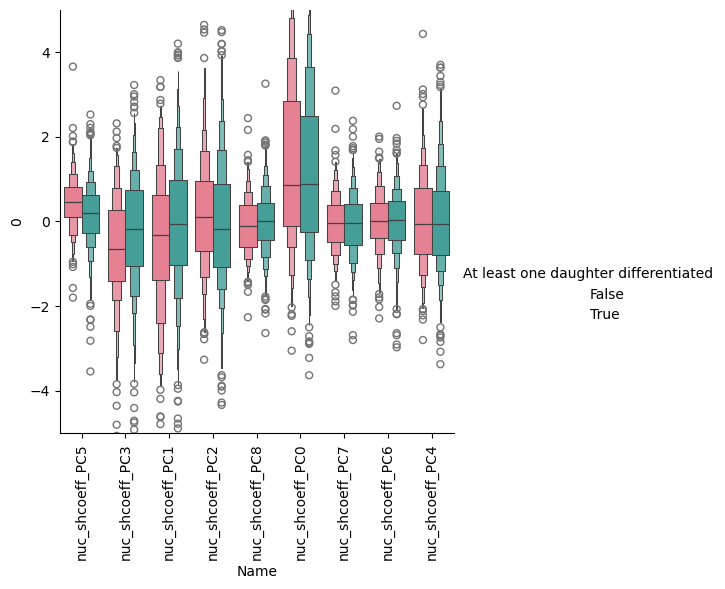

In [101]:
from scipy import stats
# _means = mother_traj.droplevel(axis=1,level=1).groupby('Num daughter differentiated')[[f'nuc_shcoeff_PC{i}' for i in range(9)]].mean()
# order = pd.Series({f'nuc_shcoeff_PC{i}':
#                    sm.OLS([0,1,2],sm.add_constant(_means[f'nuc_shcoeff_PC{i}'])).fit().pvalues[f'nuc_shcoeff_PC{i}']
#                    for i in range (9)}).abs().sort_values(ascending=True)
y = 'At least one daughter differentiated'

_mean = mother_traj.droplevel(axis=1,level=1)[[f'nuc_shcoeff_PC{i}' for i in range(9)]].std()
_diff = mother_traj.droplevel(axis=1,level=1).groupby(y)[[f'nuc_shcoeff_PC{i}' for i in range(9)]].mean().diff()
order = (_diff / _mean).loc[True].T.abs().sort_values(ascending=False)
g = {name:g for name,g in mother_traj.droplevel(axis=1,level=1).groupby(y)}
print({c:stats.ttest_ind(g[False][c],g[True][c]).pvalue for c in order.index})

fig = sb.catplot(
    mother_traj.droplevel(axis=1,level=1).reset_index().set_index(['Frame','TrackID',y])[[f'nuc_shcoeff_PC{i}' for i in range(9)]].stack().reset_index(),
    x='Name',y=0,
    kind='boxen',palette='husl',
   hue=y,order=order.index,hue_order=[False,True])
plt.ylim([-5,5])
plt.xticks(rotation=90)

fig.savefig(path.join(figure_dir,'sorted_mother_difference.svg'))


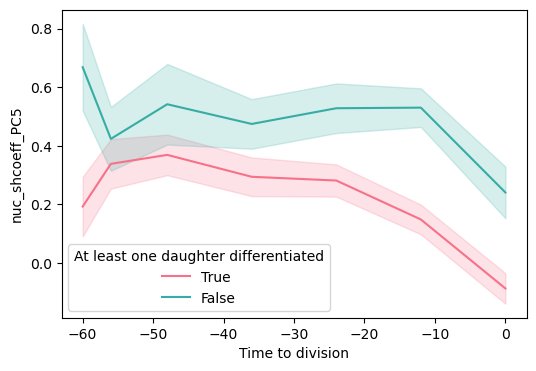

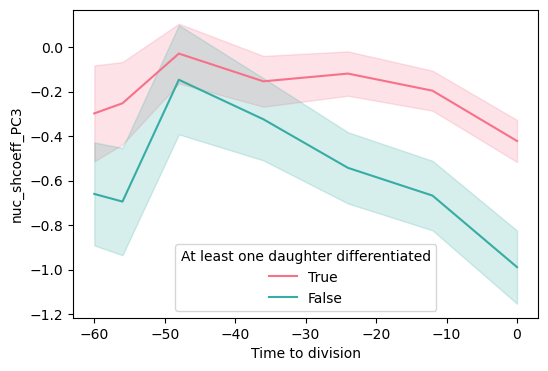

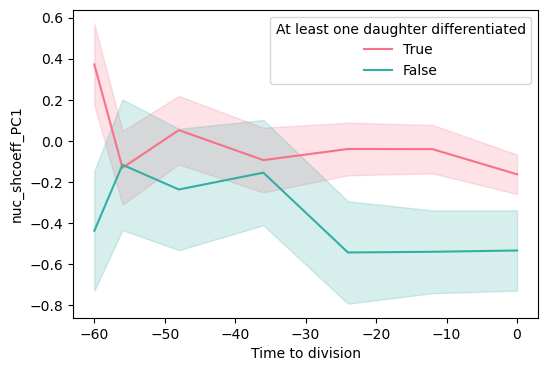

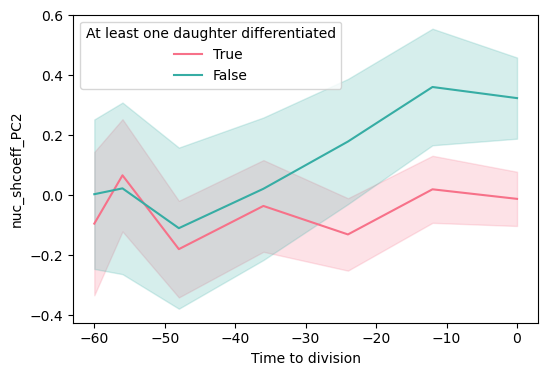

In [381]:
x = 'Time to division'
y = 'nuc_shcoeff_PC5'
fig = plt.figure(figsize=(6,4))
sb.lineplot(mother_traj.droplevel(axis=1,level=1),x='Time to division',y=y,hue='At least one daughter differentiated',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'mother_PC5_trajectory.svg'))

x = 'Time to division'
y = 'nuc_shcoeff_PC3'
fig = plt.figure(figsize=(6,4))
sb.lineplot(mother_traj.droplevel(axis=1,level=1),x='Time to division',y=y,hue='At least one daughter differentiated',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'mother_PC3_trajectory.svg'))

x = 'Time to division'
y = 'nuc_shcoeff_PC1'
fig = plt.figure(figsize=(6,4))
sb.lineplot(mother_traj.droplevel(axis=1,level=1),x='Time to division',y=y,hue='At least one daughter differentiated',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'mother_PC1_trajectory.svg'))

x = 'Time to division'
y = 'nuc_shcoeff_PC2'
fig = plt.figure(figsize=(6,4))
sb.lineplot(mother_traj.droplevel(axis=1,level=1),x='Time to division',y=y,hue='At least one daughter differentiated',errorbar='se',palette='husl')
fig.savefig(path.join(figure_dir,'mother_PC2_trajectory.svg'))

## Reconstructed average cell shapes along timecourse

In [126]:
mothers_sym_stem

Name          Nuclear volume Nuclear solidity           Z           Y  \
Metadata         Measurement      Measurement Measurement Measurement   
Frame TrackID                                                           
0     R1_2               NaN              NaN         NaN         NaN   
      R1_28              NaN              NaN         NaN         NaN   
      R1_38              NaN              NaN         NaN         NaN   
      R1_53              NaN              NaN         NaN         NaN   
      R1_90              NaN              NaN         NaN         NaN   
...                      ...              ...         ...         ...   
9     R2_388             NaN              NaN         NaN         NaN   
      R2_529             NaN              NaN         NaN         NaN   
      R2_680             NaN              NaN         NaN         NaN   
      R2_817             NaN              NaN         NaN         NaN   
      R2_951             NaN              NaN         NaN         NaN   

Name                    X Nuclear height Cell volume      Z-cyto      Y-cyto  \
Metadata      Measurement    Measurement Measurement Measurement Measurement   
Frame TrackID                                                                  
0     R1_2            NaN            NaN         NaN         NaN         NaN   
      R1_28           NaN            NaN         NaN         NaN         NaN   
      R1_38           NaN            NaN         NaN         NaN         NaN   
      R1_53           NaN            NaN         NaN         NaN         NaN   
      R1_90           NaN            NaN         NaN         NaN         NaN   
...                   ...            ...         ...         ...         ...   
9     R2_388          NaN            NaN         NaN         NaN         NaN   
      R2_529          NaN            NaN         NaN         NaN         NaN   
      R2_680          NaN            NaN         NaN         NaN         NaN   
      R2_817          NaN            NaN         NaN         NaN         NaN   
      R2_951          NaN            NaN         NaN         NaN         NaN   

Name               X-cyto  ... Num neighbor division 1 frame prior  \
Metadata      Measurement  ...                         Measurement   
Frame TrackID              ...                                       
0     R1_2            NaN  ...                                 NaN   
      R1_28           NaN  ...                                 NaN   
      R1_38           NaN  ...                                 NaN   
      R1_53           NaN  ...                                 NaN   
      R1_90           NaN  ...                                 NaN   
...                   ...  ...                                 ...   
9     R2_388          NaN  ...                                 NaN   
      R2_529          NaN  ...                                 NaN   
      R2_680          NaN  ...                                 NaN   
      R2_817          NaN  ...                                 NaN   
      R2_951          NaN  ...                                 NaN   

Name          Num neighbor delamination 1 frame prior  \
Metadata                                  Measurement   
Frame TrackID                                           
0     R1_2                                        NaN   
      R1_28                                       NaN   
      R1_38                                       NaN   
      R1_53                                       NaN   
      R1_90                                       NaN   
...                                               ...   
9     R2_388                                      NaN   
      R2_529                                      NaN   
      R2_680                                      NaN   
      R2_817                                      NaN   
      R2_951                                      NaN   

Name          Num daughter differentiated  \
Metadata                       

In [130]:
age_avg = {age:_df.index for age,_df in mothers_sym_stem.groupby('Time to division')}

cells = [reconstruct_mesh_from_averaged_coeffs_(age_avg[t],coefs_raw, cyto_coef_cols, nuc_coef_cols) for t in sorted(age_avg.keys()) if len(age_avg[t]) > 2]
plot_cells_side_by_side(cells,num_grid = 5)

Widget(value='<iframe src="http://localhost:65186/index.html?ui=P_0x3d43a87a0_10&reconnect=auto" class="pyvist…

In [128]:
age_avg = {age:_df.index for age,_df in mothers_asym.groupby('Time to division')}

cells = [reconstruct_mesh_from_averaged_coeffs_(age_avg[t],coefs_raw, cyto_coef_cols, nuc_coef_cols) for t in sorted(age_avg.keys()) if len(age_avg[t]) > 2]
plot_cells_side_by_side(cells,num_grid = 5)

Widget(value='<iframe src="http://localhost:65186/index.html?ui=P_0x39e81d520_8&reconnect=auto" class="pyvista…

In [129]:
age_avg = {age:_df.index for age,_df in mothers_sym_diff.groupby('Time to division')}

cells = [reconstruct_mesh_from_averaged_coeffs_(age_avg[t],coefs_raw, cyto_coef_cols, nuc_coef_cols) for t in sorted(age_avg.keys()) if len(age_avg[t]) > 2]
plot_cells_side_by_side(cells,num_grid = 5)

Widget(value='<iframe src="http://localhost:65186/index.html?ui=P_0x304ded9d0_9&reconnect=auto" class="pyvista…